# 009. Test model on time diff (predict change of discharge)

In the first nb, absolute values were used as predictand. Here we repeat the steps and only predict changes instead of absolute values.

In [1]:
import link_src

In [ ]:
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import dask
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(processes=True) #n_workers=10, threads_per_worker=1, 
client = Client(cluster)  # memory_limit='16GB', 

import xarray as xr
from dask.diagnostics import ProgressBar

In [3]:
client

Client Scheduler: tcp://127.0.0.1:44660 Dashboard: http://127.0.0.1:36349/status,Cluster Workers: 8 Cores: 32 Memory: 203.20 GB


In [4]:
from python.aux.ml_flood_config import path_to_data
from python.aux.utils import open_data
from python.aux.utils import shift_time
# define some vars
data_path = f'{path_to_data}danube/'
print(data_path)

/home/srvx11/lehre/users/a1303583/ipython/ml_flood/data/danube/


In [ ]:
# load data
era5 = open_data(data_path, kw='era5')
glofas = open_data(data_path, kw='glofas_ra')
glofas = shift_time(glofas, -dt.timedelta(days=1))

In [9]:
if not 'lsp' in era5:
    lsp = era5['tp']-era5['cp']
    lsp.name = 'lsp'
else:
    lsp = era5['lsp']

reltop = era5['z'].sel(level=500) - era5['z'].sel(level=850)
reltop.name = 'reltop'

q_mean = era5['q'].mean('level')
q_mean.name = 'q_mean'

era5_features = xr.merge([era5['cp'], lsp, reltop, q_mean])
era5_features = era5_features.interp(latitude=glofas.latitude,
                                     longitude=glofas.longitude)
era5_features = era5_features.isel(time=slice(0*365,3*365))
glofas = glofas.isel(time=slice(0*365,3*365))

if len(era5_features.time) < 3000:
    era5_features = era5_features.load()
    glofas = glofas.load()

krems = dict(latitude=48.403, longitude=15.615)

local_region = dict(latitude=slice(krems['latitude']+1.5, 
                                   krems['latitude']-1.5),
                   longitude=slice(krems['longitude']-1.5, 
                                   krems['longitude']+1.5))

# select area of interest and average over space for all features
dis = glofas.interp(krems)
y = dis.diff('time', 1)
X = era5_features.sel(local_region).mean(['latitude', 'longitude'])
print(X)

<xarray.Dataset>
Dimensions:  (time: 1095)
Coordinates:
  * time     (time) datetime64[ns] 1981-01-01 1981-01-02 ... 1983-12-31
Data variables:
    cp       (time) float64 0.001487 0.0007091 0.000959 ... 0.0005057 4.775e-05
    lsp      (time) float64 0.0009374 0.002626 0.007884 ... 0.0001158 0.0009168
    reltop   (time) float64 3.922e+04 3.871e+04 ... 4.064e+04 4.001e+04
    q_mean   (time) float64 0.001406 0.001321 0.00244 ... 0.001818 0.001715


In [10]:
def add_shifted_predictors(ds, shifts, variables='all'):
    """Adds additional variables to an array which are shifted in time.
    
    Parameters
    ----------
    ds : xr.Dataset
    shifts : list of integers
    variables : str or list
    """
    if variables == 'all': 
        variables = ds.data_vars
        
    for var in variables:
        for i in shifts:
            if i == 0: continue  # makes no sense to shift by zero
            newvar = var+'-'+str(i)
            ds[newvar] = ds[var].shift(time=i)
    return ds
shifts = range(1,11)
notshift_vars = ['swvl1', 'swvl2']
shift_vars = [v for v in X.data_vars if not v in notshift_vars]

Xs = add_shifted_predictors(X, shifts, variables=shift_vars)
Xar = Xs.to_array(dim='features')
yar = y.to_array()

# singleton dimension has to have the same name like in X
# so we set it to 'features' too
yar = yar.rename({'variable': 'features'})

# it confuses the concat if one has latitude but the other not
yar = yar.drop(['latitude', 'longitude'])
Xy = xr.concat([Xar, yar], dim='features')  

# drop them as we cannot train on nan values
Xyt = Xy.dropna('time', how='any')
predictand = 'dis'
predictors = [v for v in Xyt.coords['features'].values if v != predictand]

In [11]:
Xda = Xyt.loc[predictors]
yda = Xyt.loc[predictand]
time = yda.time
Xda = Xda.chunk(dict(time=-1, features=-1)).data.T
yda = yda.data.squeeze()

In [12]:
import joblib
from sklearn.pipeline import Pipeline
from dask_ml.preprocessing import StandardScaler
from dask_ml.decomposition import PCA

#from dask_ml.xgboost import XGBRegressor
from dask_ml.linear_model import LogisticRegression
from dask_ml.linear_model import LinearRegression

In [13]:
model_kws = dict(n_jobs=-1, max_iter=10000, verbose=True)

pipe = Pipeline([('scaler', StandardScaler()),
                 #('pca', PCA(n_components=6)),
                 ('model', LinearRegression(**model_kws)),],
                verbose=True)

In [14]:
Xda = Xda.persist()

with ProgressBar():
    pipe.fit(Xda, yda)

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.1s
[Pipeline] ............. (step 2 of 2) Processing model, total=   1.3s


### In sample test for change in discharge

In [15]:
def add_time(vector, time, name=None):
    """Converts arrays to xarrays with a time coordinate."""
    return xr.DataArray(vector, dims=('time'), coords={'time': time}, name=name)

In [16]:
with ProgressBar():
    ytest = pipe.predict(Xda)

In [17]:
ytest = add_time(ytest, time, name='dis-forecast')
ytest_dis = ytest.cumsum('time')
# initial state + changes = timeseries of forecasted discharge
ytest_dis += dis['dis'][0]

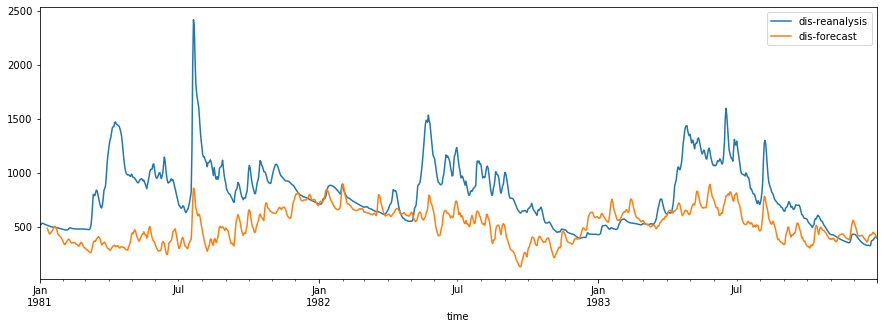

In [20]:
fig, ax = plt.subplots(figsize=(15,5))
dis['dis'].to_pandas().plot(ax=ax, label='dis-reanalysis')
ytest_dis.to_pandas().plot(ax=ax, label='dis-forecast')
plt.legend()

Text(0, 0.5, 'river discharge [m$^3$/s]')

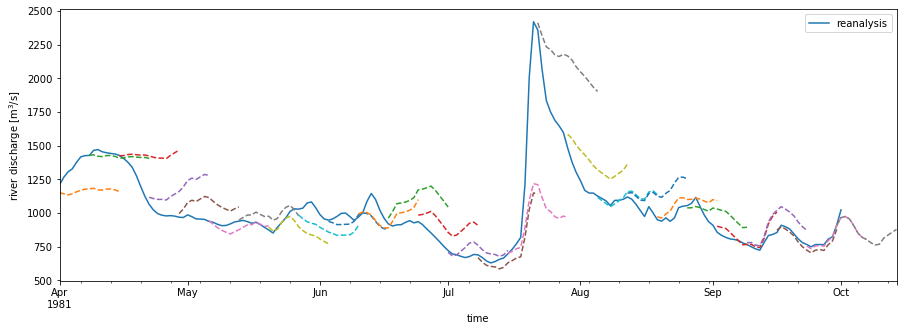

In [19]:

tstart, tend = dt.datetime(1981,4,1), dt.datetime(1981,10,1)
dt_runs = dt.timedelta(days=7)
dt_fxrange = dt.timedelta(days=14) 

fig, ax = plt.subplots(figsize=(15,5))
dis['dis'].sel(time=slice(tstart,tend)).to_pandas().plot(ax=ax, label='reanalysis')
plt.legend()
t = tstart
while t < tend:
    t0, t1 = t, t+dt_fxrange
    tm1 = t0-dt.timedelta(days=1)
    
    fcst = dis['dis'].sel(time=tm1) + ytest.sel(time=slice(t0, t1)).cumsum()  # forecast
    fcst.to_pandas().plot(ax=ax, label='forecast', linestyle='--') #, color='r')
    
    t += dt_runs
    

ax.set_ylabel('river discharge [m$^3$/s]')